In [1]:
import torch
import numpy as np
import auction
import torch.nn as nn
import torch.nn.functional as F
import timeit
import sinkhorn
import matplotlib.pyplot as plt

In [2]:
manual_seed = 137
np.random.seed(seed=manual_seed)
torch.manual_seed(manual_seed)

In [3]:
#distrib = torch.distributions.Exponential(torch.tensor([1.0]))
size_batch = (int)(10**4)
print(size_batch)
K=10
#y = torch.tensor([0.5, 1])
y = torch.linspace(1./K, 1., K) # discretization of uniform distribution
beta= torch.ones(K)/K
print(y)
print(beta)

10000
tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000])
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])


In [4]:
net = auction.BidderStrategy(size_layer=100, nactions=12)

In [5]:
net.fc2[0].weight

Parameter containing:
tensor([[ 2.6828e-03,  3.2739e-03,  2.0593e-03, -3.6023e-04,  7.8904e-04,
          2.3994e-03,  1.5555e-03,  1.8953e-03,  2.6183e-03,  3.0506e-03,
          3.9563e-03,  2.4867e-03,  2.4430e-03,  3.4211e-03,  1.8198e-03,
          1.4487e-03,  1.7990e-03,  2.5922e-03,  2.2571e-03,  2.0627e-03,
          1.5421e-03,  2.0135e-03,  1.8130e-03,  3.1192e-04,  8.1580e-04,
          2.1807e-03,  3.2378e-03,  1.1406e-03,  1.2194e-03,  9.3078e-04,
          1.4787e-03,  1.4434e-03,  1.8297e-03,  6.9470e-04,  8.7907e-04,
          6.1963e-04,  8.8817e-04,  2.2209e-03,  3.1621e-03,  2.4993e-04,
          1.6237e-03,  1.5047e-03,  9.6659e-04,  3.0214e-03,  1.5383e-03,
          1.9751e-03,  2.1705e-03,  1.8892e-03,  2.2922e-03,  1.1585e-03,
          2.8189e-03,  2.6735e-03,  1.3160e-03,  2.2532e-03, -3.2562e-05,
          1.9620e-03,  1.8526e-03,  9.0057e-04,  1.2435e-03,  1.0705e-03,
          1.9442e-03,  1.9257e-03,  2.2064e-03,  9.2227e-04,  2.2664e-03,
          3.1297

In [6]:
distrib = torch.distributions.Exponential(torch.tensor(1.))

In [7]:
input = torch.zeros((size_batch, 1),requires_grad=True)
samples = distrib.sample((size_batch, 1))
input.data = samples.clone()
print(input.size())

torch.Size([10000, 1])


In [8]:
time = timeit.default_timer()
C = auction.LazySecondPriceLoss(net, input, y, size_batch, distribution="exponential")
print('done in {0} s'.format(timeit.default_timer()-time))
print(C)

done in 0.10155601499991462 s
tensor([[0.9943, 0.9693, 0.9442, 0.9192, 0.8941, 0.8691, 0.8440, 0.8190, 0.7939,
         0.7689],
        [1.0080, 0.9701, 0.9322, 0.8942, 0.8563, 0.8184, 0.7804, 0.7425, 0.7046,
         0.6666],
        [1.0814, 1.0190, 0.9565, 0.8941, 0.8317, 0.7693, 0.7068, 0.6444, 0.5820,
         0.5195],
        [1.0675, 1.0051, 0.9427, 0.8803, 0.8179, 0.7555, 0.6931, 0.6307, 0.5683,
         0.5058],
        [1.1544, 1.0841, 1.0138, 0.9436, 0.8733, 0.8030, 0.7327, 0.6624, 0.5921,
         0.5219],
        [1.2847, 1.1994, 1.1142, 1.0289, 0.9436, 0.8584, 0.7731, 0.6878, 0.6026,
         0.5173],
        [1.1845, 1.1028, 1.0211, 0.9395, 0.8578, 0.7761, 0.6945, 0.6128, 0.5311,
         0.4495],
        [1.1961, 1.1184, 1.0406, 0.9629, 0.8851, 0.8074, 0.7296, 0.6519, 0.5742,
         0.4964],
        [1.3231, 1.2417, 1.1603, 1.0790, 0.9976, 0.9163, 0.8349, 0.7536, 0.6722,
         0.5908],
        [1.3148, 1.2212, 1.1277, 1.0341, 0.9406, 0.8470, 0.7534, 0.6599, 0.5663

# Sinkhorn

## Train network

In [30]:
net = auction.BidderStrategy(size_layer=100, nactions=12)
net.projection()
lamb = 0.0005
niter_sink = 1000
niter = 1000
lr = 0.01
batch = 1000

In [31]:
loss_profile = auction.train_sinkhorn_auction(net, y, beta, lamb=lamb, niter_sink=niter_sink, max_iter=niter, 
                                              learning_rate=lr, err_threshold=1e-3, verbose=True, verbose_freq=100, size_batch=batch, experiment=1)

Loss at iterations 100: 0.7401291131973267
Loss at iterations 200: 0.7561506628990173
Loss at iterations 300: 0.742348313331604
Loss at iterations 400: 0.7492515444755554
Loss at iterations 500: 0.754898726940155
Loss at iterations 600: 0.7454567551612854
Loss at iterations 700: 0.7646266222000122
Loss at iterations 800: 0.7527252435684204
Loss at iterations 900: 0.7478716373443604
Loss at iterations 1000: 0.7563729882240295
done in 246.7333107610002 s


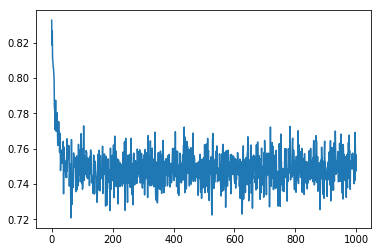

In [32]:
plt.plot(loss_profile)

In [33]:
loss, gamma, C, _, _ = auction.eval(net, y, beta, lamb=lamb, niter_sink=(int)(1e5), size_batch=100000)

In [34]:
print('True loss:{}'.format(loss))
print('Utility loss:{}'.format(torch.sum(gamma*C)))
alpha = torch.sum(gamma, dim=1)
print('Privacy loss:{}'.format(sinkhorn._KL(alpha, beta, gamma, epsilon=0)))

True loss:0.7487383484840393
Utility loss:0.747927725315094
Privacy loss:1.6213047504425049


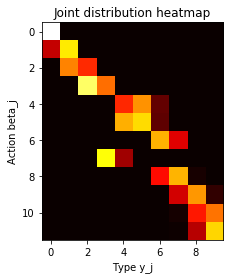

In [35]:
plt.figure()
plt.title('Joint distribution heatmap')
plt.xlabel('Type y_j')
plt.ylabel('Action beta_j')
plt.imshow(gamma.detach().numpy(), cmap='hot')
#plt.savefig('figures/gamma_heatmap_lamb{}.png'.format(lamb))
plt.show()

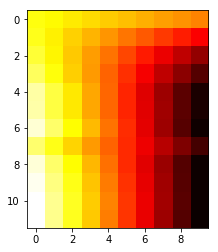

In [36]:
plt.imshow(C.detach().numpy(), cmap='hot')
plt.show()

# Comparing with GPU

# Test